In [6]:
###IMPORT DEPENDENCIES

In [7]:
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

In [8]:
df = pd.read_csv('mail_data.csv')
df.columns = ["label", "message"]
df.dropna(inplace=True)

In [9]:
df.shape

(5572, 2)

In [13]:
# ============================================
# 3. CLEAN TEXT
# ============================================
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)
    text = re.sub(f"[{string.punctuation}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df["clean"] = df["message"].apply(clean_text)

In [18]:
df.iloc[0:2]['clean']

0    go until jurong point crazy available only in ...
1                              ok lar joking wif u oni
Name: clean, dtype: object

In [15]:
# ============================================
# 4. LABEL ENCODING
# ============================================
le = LabelEncoder()
df["label_enc"] = le.fit_transform(df["label"])  # ham=0, spam=1

X = df["clean"]
y = df["label_enc"]

In [19]:
# ============================================
# 5. TF-IDF (STRONG SETTINGS)
# ============================================
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),      # unigrams + bigrams boost performance
    stop_words="english",
    sublinear_tf=True       # improves SVM performance
)

X_tfidf = tfidf.fit_transform(X)

In [20]:
# ============================================
# 6. TRAIN/TEST SPLIT
# ============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

In [25]:
X_train.shape

(4457, 5000)

In [26]:
X_test.shape

(1115, 5000)

In [21]:
# ============================================
# 7. LINEAR SVM (BEST FOR TEXT)
# ============================================
svm = LinearSVC(class_weight="balanced")

# Optional hyperparameter tuning
params = {
    "C": [0.1, 1, 5, 10]
}

grid = GridSearchCV(svm, params, cv=5, scoring="f1")
grid.fit(X_train, y_train)

best_svm = grid.best_estimator_

In [22]:
# ============================================
# 8. PREDICTION & METRICS
# ============================================
y_pred = best_svm.predict(X_test)

print("\n========= MODEL PERFORMANCE =========")
print("Best C:", grid.best_params_["C"])
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))



========= MODEL PERFORMANCE =========
Best C: 1
Accuracy: 0.9874439461883409

Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.91      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



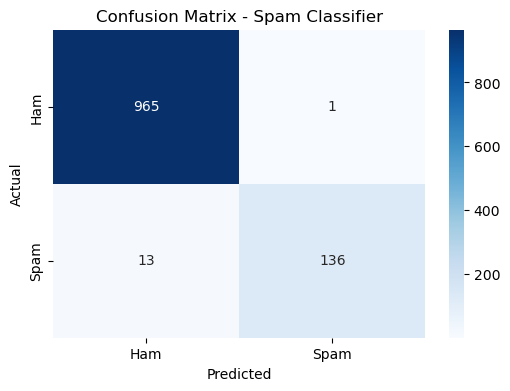

In [27]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================
# CONFUSION MATRIX
# ============================================
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.title("Confusion Matrix - Spam Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
